In [1]:
import torch
import numpy as np
import os, sys
from pathlib import Path
import tempfile

ROOT = Path.cwd().parent          # notebooks 的上一级就是项目根目录
sys.path.insert(0, str(ROOT))     # 放到最前面，优先级最高

print("cwd:", Path.cwd())
print("root added:", ROOT)

cwd: C:\Users\28547\anaconda_projects\Deep Learning Pack\notebooks
root added: C:\Users\28547\anaconda_projects\Deep Learning Pack


# Utils Test

In [2]:
from dlphys.utils.seed import set_seed
from dlphys.utils.device import get_device, to_device
from dlphys.utils.io import ensure_dir, save_json, load_json, append_jsonl

print("== device test ==")
dev = get_device("cuda")
print("resolved device:", dev)

print("== seed reproducibility test ==")
set_seed(123)
a1 = torch.rand(3)
b1 = np.random.rand(3)

set_seed(123)
a2 = torch.rand(3)
b2 = np.random.rand(3)

assert torch.allclose(a1, a2), "torch seed not reproducible"
assert np.allclose(b1, b2), "numpy seed not reproducible"
print("seed ok")

print("== to_device recursion test ==")
batch = {"x": torch.randn(2,3), "y": torch.tensor([1,0]), "meta": {"z": torch.ones(1)}}
batch2 = to_device(batch, dev)
assert batch2["x"].device == dev
assert batch2["y"].device == dev
assert batch2["meta"]["z"].device == dev
print("to_device ok")

print("== io test ==")
with tempfile.TemporaryDirectory() as td:
    td = Path(td)
    ensure_dir(td / "a/b/c")
    save_json(td / "cfg.json", {"hello": "world", "n": 1})
    obj = load_json(td / "cfg.json")
    assert obj["hello"] == "world" and obj["n"] == 1

    logp = td / "metrics.jsonl"
    append_jsonl(logp, {"epoch": 0, "loss": 1.23})
    append_jsonl(logp, {"epoch": 1, "loss": 0.98})
    lines = logp.read_text(encoding="utf-8").strip().splitlines()
    assert len(lines) == 2
print("io ok")

print("\nAll v0 utils tests passed ✅")


== device test ==
resolved device: cpu
== seed reproducibility test ==
seed ok
== to_device recursion test ==
to_device ok
== io test ==
io ok

All v0 utils tests passed ✅


In [8]:
# # ===== Notebook bootstrap (强烈建议固定放在最上面) =====
# %load_ext autoreload
# %autoreload 2

import sys
from pathlib import Path
ROOT = Path.cwd().parent
sys.path.insert(0, str(ROOT))

print("ROOT:", ROOT)

# ===== v1 tests =====
import tempfile
from pathlib import Path as P

from dlphys.utils.time import now_str, human_time, Timer
from dlphys.utils.loggers import get_logger, clear_handlers, close_file_handlers

print("== time utils test ==")
s = now_str()
assert isinstance(s, str) and len(s) >= 10
assert human_time(12.3).endswith("s")
assert "m" in human_time(70)  # "1m 10s" like
with Timer() as t:
    _ = sum(range(200000))
dt = t.elapsed()
assert dt >= 0.0
print("now_str:", s)
print("elapsed:", human_time(dt))
print("time ok ✅")

print("\n== logger test (temp dir, repeat-safe) ==")

# 关键：为了确保 notebook 重复运行不会复用旧 handler，
# 我们用 reset=True 或者换一个 logger name。
# 这里用 reset=True，更适合你以后写实验脚手架。
for _ in range(3):
    with tempfile.TemporaryDirectory() as td:
        td = P(td)
        log_path = td / "test.log"

        logger = get_logger("dlphys.test", log_file=log_path, reset=True)
        logger.info("hello logger")
        logger.warning("warn")

        # 关键：离开 TemporaryDirectory 前关闭 file handler，释放 Windows 文件锁
        close_file_handlers(logger)

        text = log_path.read_text(encoding="utf-8")
        assert "hello logger" in text and "warn" in text

print("logger ok ✅ (repeat-safe)")

print("\nAll v1 tests passed ✅")


[14:59:20][INFO][dlphys.test] hello logger
[14:59:20][WARNING][dlphys.test] warn
[14:59:20][INFO][dlphys.test] hello logger
[14:59:20][WARNING][dlphys.test] warn
[14:59:20][INFO][dlphys.test] hello logger
[14:59:20][WARNING][dlphys.test] warn


ROOT: C:\Users\28547\anaconda_projects\Deep Learning Pack
== time utils test ==
now_str: 20251230-145919
elapsed: 0.0s
time ok ✅

== logger test (temp dir, repeat-safe) ==
logger ok ✅ (repeat-safe)

All v1 tests passed ✅


In [5]:
%load_ext autoreload
%autoreload 2

import sys
from pathlib import Path
ROOT = Path.cwd().parent
sys.path.insert(0, str(ROOT))

import torch
import torch.nn as nn

from dlphys.utils.hooks import ActivationCacher
from dlphys.utils.stats import RunningMeanVar, RunningMoments

print("== hooks test ==")
model = nn.Sequential(
    nn.Linear(4, 8),
    nn.ReLU(),
    nn.Linear(8, 2),
)

x = torch.randn(5, 4)

# Cache all Linear layers by type
with ActivationCacher(model, module_types=(nn.Linear,), detach=True, to_cpu=True, max_per_module=2) as ac:
    y1 = model(x)
    y2 = model(x)

keys = ac.record.keys()
print("cached keys:", keys)
assert len(keys) == 2
for k in keys:
    assert len(ac.record.activations[k]) == 2  # max_per_module=2 keeps last 2
    assert ac.record.activations[k][-1].device.type == "cpu"
print("hooks ok ✅")

print("\n== RunningMeanVar test ==")
r = RunningMeanVar()
for _ in range(5):
    r.update(torch.randn(10).reshape(-1))
assert r.count == 5
assert r.mean is not None
assert r.var is not None
print("mean shape:", r.mean.shape, "var shape:", r.var.shape)
print("RunningMeanVar ok ✅")

print("\n== RunningMoments test ==")
m = RunningMoments()
m.update(torch.randn(1000))
assert m.n == 1000
assert m.var is not None
print("mean:", m.mean, "std:", m.std, "skew:", m.skew, "kurt_excess:", m.kurtosis_excess)
print("RunningMoments ok ✅")

print("\nAll v2 tests passed ✅")


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
== hooks test ==
cached keys: ['0', '2']
hooks ok ✅

== RunningMeanVar test ==
mean shape: (10,) var shape: (10,)
RunningMeanVar ok ✅

== RunningMoments test ==
mean: -0.004746956891962321 std: 0.9725930164965622 skew: 0.09158734900229236 kurt_excess: 0.25469578864364006
RunningMoments ok ✅

All v2 tests passed ✅


# Config Test

In [11]:
%load_ext autoreload
%autoreload 2

import sys
from pathlib import Path
ROOT = Path.cwd().parent  # notebooks/ 的上一级就是项目根目录
sys.path.insert(0, str(ROOT))

from dlphys.config import ExperimentConfig
from dlphys.utils.loggers import get_logger, close_file_handlers

# 1) Create config
cfg = ExperimentConfig(project_name="demo", seed=42, device="cpu", deterministic=False)
cfg.resolve_paths(base_dir=ROOT)  # 关键：让它用项目根目录来生成 runs/
print(cfg.run_name)
print(cfg.resolved)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
20251230-152140_demo
{'project_root': 'C:\\Users\\28547\\anaconda_projects\\Deep Learning Pack', 'runs_parent': 'C:\\Users\\28547\\anaconda_projects\\Deep Learning Pack\\runs', 'run_dir': 'C:\\Users\\28547\\anaconda_projects\\Deep Learning Pack\\runs\\20251230-152140_demo', 'log_path': 'C:\\Users\\28547\\anaconda_projects\\Deep Learning Pack\\runs\\20251230-152140_demo\\train.log'}


In [6]:
%load_ext autoreload
%autoreload 2

import sys
from pathlib import Path
ROOT = Path.cwd().parent  # notebooks/ 的上一级就是项目根目录
sys.path.insert(0, str(ROOT))

from dlphys.config import ExperimentConfig
from dlphys.utils.loggers import get_logger, close_file_handlers

# 1) Create config
cfg = ExperimentConfig(project_name="demo", seed=42, device="cpu", deterministic=False)
cfg.resolve_paths(base_dir=ROOT)  # 关键：让它用项目根目录来生成 runs/
print(cfg.run_name)
print(cfg.resolved)

# 2) Save/Load
cfg_path = cfg.run_dir_abs / "config.json"
cfg.save(cfg_path)
cfg2 = ExperimentConfig.load(cfg_path)
cfg2.resolve_paths(base_dir=ROOT)  # 再 resolve 一次拿到绝对路径
print("loaded ok:", cfg2.project_name, cfg2.seed)

# 3) Logger writes into run_dir
logger = get_logger("dlphys.demo", log_file=cfg.log_path_abs, reset=True)
logger.info("hello from config v0")
close_file_handlers(logger)

# 4) Verify log exists
assert cfg.log_path_abs.exists()
print("config v0 test passed ✅")
print("log file:", cfg.log_path_abs)


[14:28:43][INFO][dlphys.demo] hello from config v0


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
20251230-142843_demo
{'project_root': 'C:\\Users\\28547\\anaconda_projects\\Deep Learning Pack', 'runs_parent': 'C:\\Users\\28547\\anaconda_projects\\Deep Learning Pack\\runs', 'run_dir': 'C:\\Users\\28547\\anaconda_projects\\Deep Learning Pack\\runs\\20251230-142843_demo', 'log_path': 'C:\\Users\\28547\\anaconda_projects\\Deep Learning Pack\\runs\\20251230-142843_demo\\train.log'}
loaded ok: demo 42
config v0 test passed ✅
log file: C:\Users\28547\anaconda_projects\Deep Learning Pack\runs\20251230-142843_demo\train.log


In [12]:
%load_ext autoreload
%autoreload 2

import sys
from pathlib import Path
ROOT = Path.cwd().parent
sys.path.insert(0, str(ROOT))

import torch
import torch.nn as nn

from dlphys.config import ExperimentConfig, register_model, build_model, build_optimizer
from dlphys.utils.loggers import get_logger, close_file_handlers

# 注册一个 toy model（你后面真正的模型会放到 dlphys/models/ 里注册）
@register_model("toy_mlp", overwrite=True)
def make_toy_mlp(cfg: ExperimentConfig, in_dim=4, width=16, out_dim=2):
    return nn.Sequential(nn.Linear(in_dim, width), nn.ReLU(), nn.Linear(width, out_dim))

cfg = ExperimentConfig(project_name="demo_registry", seed=0, device="cpu")
cfg.extra["model_name"] = "toy_mlp"
cfg.extra["model_kwargs"] = {"in_dim": 4, "width": 32, "out_dim": 3}
cfg.extra["optim_name"] = "adamw"
cfg.extra["optim_kwargs"] = {"lr": 1e-3, "weight_decay": 1e-2}

cfg.resolve_paths(base_dir=ROOT)

model = build_model(cfg)
opt = build_optimizer(cfg, model.parameters())

x = torch.randn(8, 4)
y = model(x)
assert y.shape == (8, 3)

logger = get_logger("dlphys.demo_registry", log_file=cfg.log_path_abs, reset=True)
logger.info(f"model={model}")
logger.info(f"optimizer={opt.__class__.__name__}")
close_file_handlers(logger)

print("config v0 registry test passed ✅")
print("run_dir:", cfg.run_dir_abs)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[16:01:12][INFO][dlphys.demo_registry] model=Sequential(
  (0): Linear(in_features=4, out_features=32, bias=True)
  (1): ReLU()
  (2): Linear(in_features=32, out_features=3, bias=True)
)
[16:01:12][INFO][dlphys.demo_registry] optimizer=AdamW


config v0 registry test passed ✅
run_dir: C:\Users\28547\anaconda_projects\Deep Learning Pack\runs\20251230-160110_demo_registry


# Core Test

In [13]:
%load_ext autoreload
%autoreload 2

import sys
from pathlib import Path
ROOT = Path.cwd().parent
sys.path.insert(0, str(ROOT))

import torch
import torch.nn as nn

from dlphys.config import ExperimentConfig, register_model
from dlphys.core import Run
from dlphys.utils.loggers import close_file_handlers

# 1) 注册一个 toy model（模拟你以后放在 models/ 里的东西）
@register_model("toy_mlp", overwrite=True)
def make_toy_mlp(cfg: ExperimentConfig, in_dim=4, width=16, out_dim=3):
    return nn.Sequential(nn.Linear(in_dim, width), nn.ReLU(), nn.Linear(width, out_dim))

# 2) 创建 cfg（v0: 用 cfg.extra 携带 registry 所需的信息）
cfg = ExperimentConfig(project_name="demo_run", seed=123, device="cpu", dtype="float32", max_epochs=1)
cfg.extra["model_name"] = "toy_mlp"
cfg.extra["model_kwargs"] = {"in_dim": 4, "width": 32, "out_dim": 3}
cfg.extra["optim_name"] = "adamw"
cfg.extra["optim_kwargs"] = {"lr": 1e-3, "weight_decay": 0.0}

# 3) Prepare + Build
run = Run(cfg)
ctx = run.prepare(base_dir=ROOT)
run.save_config()
ctx = run.build()

# 4) 做一次前向，验证 device/dtype/shape
x = torch.randn(8, 4, device=ctx.device, dtype=ctx.dtype)
y = ctx.model(x)
assert y.shape == (8, 3)

# 5) 关闭 file handler（避免 Windows 临时锁 / notebook 反复运行出幺蛾子）
close_file_handlers(ctx.logger)

print("core v0 Run test passed ✅")
print("run_dir:", ctx.run_dir)
print("log_path:", ctx.log_path)
print("config saved:", (ctx.run_dir / "config.json").exists())


[18:57:51][INFO][demo_run.run] Run prepared: run_dir=C:\Users\28547\anaconda_projects\Deep Learning Pack\runs\20251230-185751_demo_run
[18:57:51][INFO][demo_run.run] device=cpu, dtype=torch.float32, seed=123, deterministic=False
[18:57:51][INFO][demo_run.run] Saved config: C:\Users\28547\anaconda_projects\Deep Learning Pack\runs\20251230-185751_demo_run\config.json
[18:57:51][INFO][demo_run.run] Built model: Sequential
[18:57:51][INFO][demo_run.run] Built optimizer: AdamW


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
core v0 Run test passed ✅
run_dir: C:\Users\28547\anaconda_projects\Deep Learning Pack\runs\20251230-185751_demo_run
log_path: C:\Users\28547\anaconda_projects\Deep Learning Pack\runs\20251230-185751_demo_run\train.log
config saved: True


# Train Test

In [14]:
%load_ext autoreload
%autoreload 2

import sys
from pathlib import Path
ROOT = Path.cwd().parent
sys.path.insert(0, str(ROOT))

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

from dlphys.training import Trainer, Callback, CallbackList

# ---- make toy data ----
torch.manual_seed(0)
x = torch.randn(256, 4)
W = torch.randn(4, 3)
y = x @ W + 0.1 * torch.randn(256, 3)

loader = DataLoader(TensorDataset(x, y), batch_size=32, shuffle=True)

# ---- toy model ----
model = nn.Sequential(nn.Linear(4, 16), nn.ReLU(), nn.Linear(16, 3))
device = torch.device("cpu")
model.to(device)

opt = torch.optim.AdamW(model.parameters(), lr=1e-2)
loss_fn = nn.MSELoss()

# ---- callback to prove hooks are called ----
class PrintCallback(Callback):
    def on_fit_start(self, trainer, state):
        print("fit_start")

    def on_epoch_start(self, trainer, state):
        print(f"epoch_start: {state.epoch}")

    def on_step_end(self, trainer, state, batch, outputs):
        if state.step % 20 == 0:
            print(f"step {state.step} loss={state.metrics['loss']:.4f}")

    def on_fit_end(self, trainer, state):
        print("fit_end, last metrics:", state.metrics)

cbs = CallbackList([PrintCallback()])

trainer = Trainer(device=device, callbacks=cbs)
state = trainer.fit(model=model, optimizer=opt, train_loader=loader, loss_fn=loss_fn, max_epochs=2)

print("training v0 test passed ✅, steps:", state.step)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
fit_start
epoch_start: 0
epoch_start: 1
fit_end, last metrics: {'loss': 4.814449787139893}
training v0 test passed ✅, steps: 16


# Minimal Model

In [1]:
%load_ext autoreload
%autoreload 2

import sys
from pathlib import Path

# 让 notebook 能 import 到项目包 dlphys
ROOT = Path.cwd().parent      # notebooks/ 的上一级就是项目根目录
sys.path.insert(0, str(ROOT))

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

from dlphys.config import ExperimentConfig, register_model
from dlphys.core import Run
from dlphys.training import Trainer, Callback, CallbackList
from dlphys.utils.loggers import close_file_handlers

# -----------------------
# 1) 注册一个最小模型（走 registry）
# -----------------------
@register_model("toy_mlp", overwrite=True)
def make_toy_mlp(cfg: ExperimentConfig, in_dim=4, width=32, out_dim=3):
    return nn.Sequential(
        nn.Linear(in_dim, width),
        nn.ReLU(),
        nn.Linear(width, out_dim),
    )

# -----------------------
# 2) 构造最小数据（线性回归）
# -----------------------
torch.manual_seed(0)
N, in_dim, out_dim = 256, 4, 3
x = torch.randn(N, in_dim)
W = torch.randn(in_dim, out_dim)
y = x @ W + 0.1 * torch.randn(N, out_dim)

train_loader = DataLoader(TensorDataset(x, y), batch_size=32, shuffle=True)

# -----------------------
# 3) 配置 cfg（走 core/run）
# -----------------------
cfg = ExperimentConfig(
    project_name="min_loop",
    seed=123,
    device="cpu",
    dtype="float32",
    max_epochs=2,
    deterministic=False,
)
cfg.extra["model_name"] = "toy_mlp"
cfg.extra["model_kwargs"] = {"in_dim": in_dim, "width": 64, "out_dim": out_dim}
cfg.extra["optim_name"] = "adamw"
cfg.extra["optim_kwargs"] = {"lr": 1e-2, "weight_decay": 0.0}

# -----------------------
# 4) Run: prepare/build
# -----------------------
run = Run(cfg)
ctx = run.prepare(base_dir=ROOT)
run.save_config()
ctx = run.build()

# -----------------------
# 5) Trainer: fit
# -----------------------
loss_fn = nn.MSELoss()

class PrintCallback(Callback):
    def on_fit_start(self, trainer, state):
        ctx.logger.info("fit_start")

    def on_step_end(self, trainer, state, batch, outputs):
        # 每 10 step 打一次
        if state.step % 10 == 0:
            ctx.logger.info(f"step={state.step} loss={state.metrics.get('loss', None)}")

    def on_fit_end(self, trainer, state):
        ctx.logger.info(f"fit_end last_metrics={state.metrics}")

cbs = CallbackList([PrintCallback()])
trainer = Trainer(device=ctx.device, callbacks=cbs)

state = trainer.fit(
    model=ctx.model,
    optimizer=ctx.optimizer,
    train_loader=train_loader,
    loss_fn=loss_fn,
    max_epochs=cfg.max_epochs,
)

# 关闭文件句柄（Windows + notebook 反复跑很重要）
close_file_handlers(ctx.logger)

print("✅ minimal loop passed")
print("run_dir:", ctx.run_dir)
print("log_path:", ctx.log_path)
print("config exists:", (ctx.run_dir / "config.json").exists())
print("steps:", state.step, "last loss:", state.metrics.get("loss"))

[11:37:23][INFO][min_loop.run] Run prepared: run_dir=C:\Users\28547\anaconda_projects\Deep Learning Pack\runs\20251231-113721_min_loop
[11:37:23][INFO][min_loop.run] device=cpu, dtype=torch.float32, seed=123, deterministic=False
[11:37:23][INFO][min_loop.run] Saved config: C:\Users\28547\anaconda_projects\Deep Learning Pack\runs\20251231-113721_min_loop\config.json
[11:37:31][INFO][min_loop.run] Built model: Sequential
[11:37:31][INFO][min_loop.run] Built optimizer: AdamW
[11:37:31][INFO][min_loop.run] fit_start
[11:37:31][INFO][min_loop.run] step=10 loss=4.113227844238281
[11:37:31][INFO][min_loop.run] fit_end last_metrics={'loss': 0.7254676818847656}


✅ minimal loop passed
run_dir: C:\Users\28547\anaconda_projects\Deep Learning Pack\runs\20251231-113721_min_loop
log_path: C:\Users\28547\anaconda_projects\Deep Learning Pack\runs\20251231-113721_min_loop\train.log
config exists: True
steps: 16 last loss: 0.7254676818847656


In [2]:
import json
from dlphys.training.logging import JSONLLoggerCallback

metrics_path = ctx.run_dir / "metrics.jsonl"
if metrics_path.exists():
    metrics_path.unlink()  # 避免重复运行时 append 导致行数累积

# 把 JSONL callback 插进去
cbs.add(JSONLLoggerCallback(metrics_path, every_n_steps=1))

# 重新跑一次（短一点）
state = trainer.fit(
    model=ctx.model,
    optimizer=ctx.optimizer,
    train_loader=train_loader,
    loss_fn=loss_fn,
    max_epochs=1,
)

# Windows + notebook：关文件句柄（尤其你之后会读文件）
close_file_handlers(ctx.logger)

assert metrics_path.exists(), "metrics.jsonl not created"
lines = metrics_path.read_text(encoding="utf-8").strip().splitlines()
assert len(lines) > 0, "metrics.jsonl empty"

obj0 = json.loads(lines[0])
print("first record:", obj0)
print("num_lines:", len(lines))
print("✅ JSONLLoggerCallback test passed")


[12:21:28][INFO][min_loop.run] fit_start
[12:21:28][INFO][min_loop.run] fit_end last_metrics={'loss': 0.1859024316072464}


first record: {'t': 1767201688.0764046, 'epoch': 0, 'step': 1, 'metrics': {'loss': 1.4809097051620483}}
num_lines: 9
✅ JSONLLoggerCallback test passed


# Plotting Test

columns: ['t', 'epoch', 'step', 'metrics.loss', 'event']
              t  epoch  step  metrics.loss event
0  1.767202e+09      0     1      1.480910   NaN
1  1.767202e+09      0     2      0.765042   NaN
2  1.767202e+09      0     3      0.539673   NaN


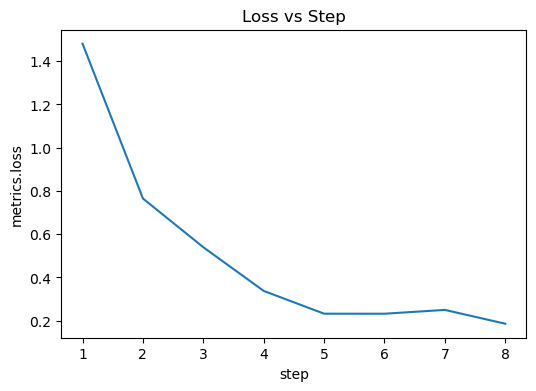

In [5]:
from dlphys.utils.jsonl import jsonl_to_df
from dlphys.utils.plotting import plot_metric

metrics_path = ctx.run_dir / "metrics.jsonl"
df = jsonl_to_df(metrics_path)

print("columns:", list(df.columns))
print(df.head(3))

ax = plot_metric(df, y="metrics.loss", x="step", title="Loss vs Step")


In [9]:
from pathlib import Path
import importlib

import dlphys.core.scan_runs as sr
importlib.reload(sr)  # 关键：确保你覆盖的新代码真的生效

project_root = Path.cwd().parent
df_runs = sr.scan_runs(project_root / "runs")
df_runs = df_runs[~df_runs["run_name"].astype(str).str.startswith(".")].reset_index(drop=True)

print("shape:", df_runs.shape)
print("columns:", list(df_runs.columns)[:40])

# 只显示“存在的列”，避免 KeyError
want = ["run_name", "has_config", "has_metrics", "num_records",
        "num_metric_records", "min_loss", "final_loss", "best_step", "last_step"]
show = [c for c in want if c in df_runs.columns]
display(df_runs[show].head(20))

# 强约束测试：不应该把 .ipynb_checkpoints 当成 run
assert not any(df_runs["run_name"].astype(str).str.startswith(".")), "still contains hidden dirs"
print("✅ scan_runs basic test passed")


shape: (1, 37)
columns: ['run_name', 'run_dir', 'mtime', 'num_records', 'has_config', 'has_metrics', 'cfg.project_name', 'cfg.run_name', 'cfg.notes', 'cfg.seed', 'cfg.deterministic', 'cfg.device', 'cfg.dtype', 'cfg.project_root', 'cfg.runs_dir', 'cfg.run_dir', 'cfg.log_file', 'cfg.batch_size', 'cfg.lr', 'cfg.weight_decay', 'cfg.max_epochs', 'cfg.extra.model_name', 'cfg.extra.model_kwargs.in_dim', 'cfg.extra.model_kwargs.width', 'cfg.extra.model_kwargs.out_dim', 'cfg.extra.optim_name', 'cfg.extra.optim_kwargs.lr', 'cfg.extra.optim_kwargs.weight_decay', 'cfg.resolved.project_root', 'cfg.resolved.runs_parent', 'cfg.resolved.run_dir', 'cfg.resolved.log_path', 'last.t', 'last.epoch', 'last.step', 'last.metrics.loss', 'last.event']


,run_name,has_config,has_metrics,num_records
0,20251231-113721_min_loop,True,True,9


✅ scan_runs basic test passed


# Model Test

In [7]:
%load_ext autoreload
%autoreload 2

import sys
from pathlib import Path
ROOT = Path.cwd().parent
sys.path.insert(0, str(ROOT))

import torch
from torch.utils.data import DataLoader, TensorDataset

# 关键：触发模型注册
import dlphys.models  # 重要：触发模型注册（你写好 models 后）

from dlphys.core import Run
from dlphys.config import ExperimentConfig
from dlphys.training.engine import Trainer
from dlphys.training.callbacks import CallbackList
from dlphys.training.logging import JSONLLoggerCallback

# -------------------------
# 1) toy regression dataset
# -------------------------
torch.manual_seed(0)
x = torch.randn(512, 4)
W = torch.randn(4, 3)
y = x @ W + 0.1 * torch.randn(512, 3)

loader = DataLoader(TensorDataset(x, y), batch_size=64, shuffle=True)

# -------------------------
# 2) config + run
# -------------------------
cfg = ExperimentConfig(
    project_root=str(ROOT),
    runs_dir="runs",
    run_name="dev_mlp_smoke",
    seed=123,
    lr=1e-2,
    weight_decay=0.0,
)
cfg.extra.update({
    "model_name": "mlp",
    "model_kwargs": dict(
        in_dim=4, out_dim=3,
        width=128, depth=4,
        activation="relu",
        norm="none",          # 你之后做 BN vs no-BN 就改这里
        residual=False,
    ),
    "optim_name": "adamw",
    "optim_kwargs": dict(lr=1e-2, weight_decay=0.0),
})

run = Run(cfg)
ctx = run.prepare()
ctx = run.build()
run.save_config()

model = ctx.model
optimizer = ctx.optimizer

# ✅ 1) JSONLLoggerCallback 参数名是 path
logger_cb = JSONLLoggerCallback(path=ctx.log_path, every_n_steps=1, also_log_epoch_end=True)

# ✅ 2) Trainer 需要 device + CallbackList
trainer = Trainer(
    device=ctx.device,
    callbacks=CallbackList([logger_cb]),
    grad_clip=None,
)

loss_fn = torch.nn.MSELoss()

state = trainer.fit(
    model=model,
    optimizer=optimizer,
    train_loader=loader,
    loss_fn=loss_fn,
    max_epochs=3,
)
print("done, last metrics:", state.metrics)
print("log file:", ctx.log_path)

handle.remove()

# -------------------------
# 5) check activation stats (rough cumulants proxy)
# -------------------------
z = preacts["last"].flatten()
mean = z.mean().item()
var = z.var(unbiased=False).item()
kurt = ((z - z.mean())**4).mean().item() / (var**2 + 1e-12)  # Pearson kurtosis
print("preact mean/var/kurt:", mean, var, kurt)
print("last logged metrics:", state.metrics)
print("log file:", ctx.log_path)


[19:06:02][INFO][dlphys.run] Run prepared: run_dir=C:\Users\28547\anaconda_projects\Deep Learning Pack\runs\dev_mlp_smoke
[19:06:02][INFO][dlphys.run] device=cpu, dtype=torch.float32, seed=123, deterministic=False
[19:06:02][INFO][dlphys.run] Built model: MLP
[19:06:02][INFO][dlphys.run] Built optimizer: AdamW
[19:06:02][INFO][dlphys.run] Saved config: C:\Users\28547\anaconda_projects\Deep Learning Pack\runs\dev_mlp_smoke\config.json


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
done, last metrics: {'loss': 0.579510509967804}
log file: C:\Users\28547\anaconda_projects\Deep Learning Pack\runs\dev_mlp_smoke\train.log
preact mean/var/kurt: -0.7779369950294495 1.304485559463501 3.6661581540304735
last logged metrics: {'loss': 0.579510509967804}
log file: C:\Users\28547\anaconda_projects\Deep Learning Pack\runs\dev_mlp_smoke\train.log


# Data Test

In [9]:
%load_ext autoreload
%autoreload 2

import sys
from pathlib import Path

ROOT = Path.cwd().parent
sys.path.insert(0, str(ROOT))

import torch

# 关键：触发 data / models 注册（import side effect）
import dlphys.data   # noqa: F401
import dlphys.models # noqa: F401

from dlphys.config import ExperimentConfig
from dlphys.core import Run
from dlphys.config.registry import build_data
from dlphys.training.engine import Trainer
from dlphys.training.callbacks import CallbackList
from dlphys.training.logging import JSONLLoggerCallback

# 1) config
cfg = ExperimentConfig(
    project_root=str(ROOT),
    runs_dir="runs",
    run_name="dev_data_pipeline",
    seed=123,
    device="cpu",
    max_epochs=2,
    batch_size=64,
)

# 2) data config
cfg.extra.update({
    "data_name": "toy_linear_regression",
    "data_kwargs": dict(
        n=512,
        in_dim=4,
        out_dim=3,
        noise_std=0.1,
        val_fraction=0.0,
        num_workers=0,
    ),
})

# 3) model/optim config
cfg.extra.update({
    "model_name": "mlp",
    "model_kwargs": dict(
        in_dim=4,
        out_dim=3,
        width=128,
        depth=3,
        activation="relu",
        norm="none",
    ),
    "optim_name": "adam",
    "optim_kwargs": dict(lr=1e-2, weight_decay=0.0),
})

# 4) run prepare/build + save config snapshot
run = Run(cfg)
ctx = run.prepare()
ctx = run.build()
run.save_config()

# 5) build data
dl = build_data(cfg)
train_loader = dl.train_loader

# 6) trainer + JSONL metrics logger
run_dir = Path(ctx.run_dir)
metrics_path = run_dir / "metrics.jsonl"   # ✅ scan_runs 约定的文件名
logger_cb = JSONLLoggerCallback(
    path=metrics_path,
    every_n_steps=1,
    also_log_epoch_end=True,
)

trainer = Trainer(
    device=ctx.device,
    callbacks=CallbackList([logger_cb]),
)

loss_fn = torch.nn.MSELoss()

state = trainer.fit(
    model=ctx.model,
    optimizer=ctx.optimizer,
    train_loader=train_loader,
    loss_fn=loss_fn,
    max_epochs=cfg.max_epochs,
)

print("OK. last metrics:", state.metrics)
print("run_dir:", run_dir)
print("train log (text):", ctx.log_path)       # 这是 logger 用的 train.log
print("metrics.jsonl:", metrics_path)
print("metrics.jsonl exists?", metrics_path.exists())

# 7) scan runs (should show has_metrics=True for this run)
from dlphys.core.scan_runs import scan_runs

runs_root = run_dir.parent  # .../runs
df = scan_runs(runs_root)
print(df.tail(5)[["run_name", "has_config", "has_metrics", "num_records"]])


[19:36:22][INFO][dlphys.run] Run prepared: run_dir=C:\Users\28547\anaconda_projects\Deep Learning Pack\runs\dev_data_pipeline
[19:36:22][INFO][dlphys.run] device=cpu, dtype=torch.float32, seed=123, deterministic=False
[19:36:22][INFO][dlphys.run] Built model: MLP
[19:36:22][INFO][dlphys.run] Built optimizer: Adam
[19:36:22][INFO][dlphys.run] Saved config: C:\Users\28547\anaconda_projects\Deep Learning Pack\runs\dev_data_pipeline\config.json


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
OK. last metrics: {'loss': 0.39530476927757263}
run_dir: C:\Users\28547\anaconda_projects\Deep Learning Pack\runs\dev_data_pipeline
train log (text): C:\Users\28547\anaconda_projects\Deep Learning Pack\runs\dev_data_pipeline\train.log
metrics.jsonl: C:\Users\28547\anaconda_projects\Deep Learning Pack\runs\dev_data_pipeline\metrics.jsonl
metrics.jsonl exists? True
                   run_name  has_config  has_metrics  num_records
0         dev_data_pipeline        True         True           18
1             dev_mlp_smoke        True        False            0
2  20251231-113721_min_loop        True         True            9
3        .ipynb_checkpoints       False        False            0


# Init Test

In [3]:
%load_ext autoreload
%autoreload 2

import sys
from pathlib import Path

ROOT = Path.cwd().parent
sys.path.insert(0, str(ROOT))

import torch

# 触发注册（import side effect）
import dlphys.data   # noqa: F401
import dlphys.models # noqa: F401
import dlphys.init   # noqa: F401  # 触发 init 注册（可选但推荐）

from dlphys.config import ExperimentConfig
from dlphys.core import Run
from dlphys.config.registry import build_data
from dlphys.training.engine import Trainer
from dlphys.training.callbacks import CallbackList
from dlphys.training.logging import JSONLLoggerCallback
from dlphys.core.scan_runs import scan_runs

# -------------------------
# 1) config
# -------------------------
cfg = ExperimentConfig(
    project_root=str(ROOT),
    runs_dir="runs",
    run_name="dev_full_pipeline_init",
    seed=123,
    device="cpu",     # 先跑通；GPU 后续再切
    max_epochs=2,
    batch_size=64,
)

# -------------------------
# 2) data config
# -------------------------
cfg.extra.update({
    "data_name": "toy_linear_regression",
    "data_kwargs": dict(
        n=512, in_dim=4, out_dim=3,
        noise_std=0.1,
        val_fraction=0.0,
        num_workers=0,
    ),
})

# -------------------------
# 3) model/optim config
# -------------------------
cfg.extra.update({
    "model_name": "mlp",
    "model_kwargs": dict(
        in_dim=4, out_dim=3,
        width=128, depth=3,
        activation="relu",
        norm="none",
    ),
    "optim_name": "adam",
    "optim_kwargs": dict(lr=1e-2, weight_decay=0.0),
})

# -------------------------
# 4) init config (NEW)
# -------------------------
cfg.extra.update({
    "init_name": "kaiming",
    "init_kwargs": dict(
        gain=1.0,
        bias="zero",
        head_scale=1.0,
        nonlinearity="relu",
        distribution="normal",
    ),
})

# -------------------------
# 5) run prepare/build/save
# -------------------------
run = Run(cfg)
ctx = run.prepare()

# 记录 init 前某个权重统计（方便验证 init 确实执行了）
def first_weight_stats(model: torch.nn.Module):
    for name, p in model.named_parameters():
        if p.ndim >= 2:  # weights
            return name, float(p.detach().mean()), float(p.detach().std())
    return None, None, None

# build 会：build_model -> to(device/dtype) -> apply_init -> build_optimizer
ctx = run.build()
run.save_config()

wname, wmean, wstd = first_weight_stats(ctx.model)
print(f"[After build+init] first weight: {wname}, mean={wmean:.3e}, std={wstd:.3e}")

# -------------------------
# 6) build data
# -------------------------
dl = build_data(cfg)
train_loader = dl.train_loader

# -------------------------
# 7) trainer + metrics logger (WRITE metrics.jsonl)
# -------------------------
run_dir = Path(ctx.run_dir)
metrics_path = run_dir / "metrics.jsonl"

logger_cb = JSONLLoggerCallback(
    path=metrics_path,
    every_n_steps=1,
    also_log_epoch_end=True,
)

trainer = Trainer(
    device=ctx.device,
    callbacks=CallbackList([logger_cb]),
)

loss_fn = torch.nn.MSELoss()

state = trainer.fit(
    model=ctx.model,
    optimizer=ctx.optimizer,
    train_loader=train_loader,
    loss_fn=loss_fn,
    max_epochs=cfg.max_epochs,
)

print("\n=== TRAIN DONE ===")
print("last state.metrics:", state.metrics)
print("run_dir:", run_dir)
print("train.log:", ctx.log_path)
print("metrics.jsonl:", metrics_path, "exists?", metrics_path.exists())

# -------------------------
# 8) scan runs summary
# -------------------------
runs_root = run_dir.parent
df = scan_runs(runs_root)

cols = ["run_name", "has_config", "has_metrics", "num_records"]
print("\n=== scan_runs tail ===")
print(df.tail(10)[cols])

# (可选) 只看本次 run 的那一行
row = df[df["run_name"] == cfg.run_name]
print("\n=== this run ===")
print(row[cols])


[14:39:42][INFO][dlphys.run] Run prepared: run_dir=C:\Users\28547\anaconda_projects\Deep Learning Pack\runs\dev_full_pipeline_init
[14:39:42][INFO][dlphys.run] device=cpu, dtype=torch.float32, seed=123, deterministic=False
[14:39:42][INFO][dlphys.run] Applying init: kaiming kwargs={'gain': 1.0, 'bias': 'zero', 'head_scale': 1.0, 'nonlinearity': 'relu', 'distribution': 'normal'}
[14:39:42][INFO][dlphys.run] Init report: {'num_modules': 4, 'head_name': None, 'head_scale': 1.0, 'init_applied': True, 'init_name': 'kaiming'}
[14:39:44][INFO][dlphys.run] Built model: MLP
[14:39:44][INFO][dlphys.run] Built optimizer: Adam
[14:39:44][INFO][dlphys.run] Saved config: C:\Users\28547\anaconda_projects\Deep Learning Pack\runs\dev_full_pipeline_init\config.json


[After build+init] first weight: blocks.0.linear.weight, mean=2.066e-02, std=6.922e-01

=== TRAIN DONE ===
last state.metrics: {'loss': 0.1550939679145813}
run_dir: C:\Users\28547\anaconda_projects\Deep Learning Pack\runs\dev_full_pipeline_init
train.log: C:\Users\28547\anaconda_projects\Deep Learning Pack\runs\dev_full_pipeline_init\train.log
metrics.jsonl: C:\Users\28547\anaconda_projects\Deep Learning Pack\runs\dev_full_pipeline_init\metrics.jsonl exists? True

=== scan_runs tail ===
                   run_name  has_config  has_metrics  num_records
0    dev_full_pipeline_init        True         True           18
1         dev_data_pipeline        True         True           18
2             dev_mlp_smoke        True        False            0
3  20251231-113721_min_loop        True         True            9
4        .ipynb_checkpoints       False        False            0

=== this run ===
                 run_name  has_config  has_metrics  num_records
0  dev_full_pipeline_init     

In [5]:
from dlphys.config.registry import build_model, build_optimizer
from dlphys.init.registry import apply_init

# 1) build model（还没 init）
model = build_model(cfg).to(ctx.device)
def weight_stats(m):
    for n,p in m.named_parameters():
        if p.ndim >= 2:
            return n, float(p.mean()), float(p.std())
    return None, None, None

n0, m0, s0 = weight_stats(model)
print("[before init]", n0, m0, s0)

# 2) apply init
report = apply_init(cfg, model, logger=ctx.logger)
n1, m1, s1 = weight_stats(model)
print("[after init ]", n1, m1, s1)
print("report:", report)

# 3) build optimizer（init 之后）
opt = build_optimizer(cfg, model.parameters())


[14:43:21][INFO][dlphys.run] Applying init: kaiming kwargs={'gain': 1.0, 'bias': 'zero', 'head_scale': 1.0, 'nonlinearity': 'relu', 'distribution': 'normal'}
[14:43:21][INFO][dlphys.run] Init report: {'num_modules': 4, 'head_name': None, 'head_scale': 1.0, 'init_applied': True, 'init_name': 'kaiming'}


[before init] blocks.0.linear.weight -0.01803046464920044 0.2861119508743286
[after init ] blocks.0.linear.weight -0.00559248449280858 0.6870200037956238
report: {'num_modules': 4, 'head_name': None, 'head_scale': 1.0, 'init_applied': True, 'init_name': 'kaiming'}
